<a href="https://colab.research.google.com/github/Vjttapcode/Vietnamese-SMS-Spam-Detection/blob/main/Vietnamese_SMS_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
#Cài đặt thư viện
!pip install transformers torch scikit-learn pandas
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
#import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #vẽ biểu đồ, trực quan hoá dữ liệu
import seaborn as sns #vẽ biểu đồ thống kê
import re #xử lý biểu thức chính quy
import string#
import torch
import math
from collections import Counter
#from pyvi import ViTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    AutoConfig,
)
from torch.optim import AdamW
from torch.utils.data import Dataset,DataLoader, TensorDataset


# Dataset


In [ ]:
import random
import calendar
import re
import unicodedata

# synonym replacement
SYNONYMS = {
    "giảm giá": ["sale", "hạ giá", "xả kho", "deal hot"],
    "khuyến mãi": ["promo", "ưu đãi", "ưu đãi sốc"],
    "nhận quà": ["nhận gift", "nhận quà tặng"],
    "liên hệ": ["LH", "call ngay", "liên lạc"],
    "đăng ký": ["đk", "ghi danh", "tham gia"],
    "quà": ["gift", "phần quà", "quà tặng"],
    "voucher": ["mã giảm", "coupon", "mã ưu đãi"],
    "freeship": ["miễn phí vận chuyển", "freeship toàn quốc"]
}

def synonym_replace(text, prob=0.2):
    for src, tgt_list in SYNONYMS.items():
        if random.random() < prob and src in text:
            text = text.replace(src, random.choice(tgt_list))
    return text

# random date
def random_date(start_year=2004, end_year=2025) -> str:
    year = random.randint(start_year, end_year)
    month = random.randint(1, 12)
    _, max_day = calendar.monthrange(year, month)
    day = random.randint(1, max_day)
    return f"{day:02d}/{month:02d}/{year}"

# inject typo
def inject_typo(text, prob):
    # Loại bỏ dấu với xác suất prob
    if random.random() < prob:
        text = unicodedata.normalize('NFD', text)
        text = re.sub(r'[\u0300-\u036f]', '', text)
    # Hoán vị hai ký tự (typo) với xác suất prob
    if random.random() < prob and len(text) > 1:
        idx = random.randint(0, len(text)-2)
        lst = list(text)
        lst[idx], lst[idx+1] = lst[idx+1], lst[idx]
        text = "".join(lst)
    return text

# Các mẫu cho tin nhắn spam
URL_LIST = [
    "http://example.com", "https://chiase.mobifone.vn", "https://smarttravel.vn",
    "https://fpt-voice.net", "https://promo.now.vn/deal", "http://shop.example.com/giamgia"
]
PHONE_LIST = [
    "0930451223", "093.045.1223", "093-045-1223", "0975551945", "097.555.1945", "097-555-1945"
]
MONEY_LIST = [
    "100k", "200k", "500k", "1.000.000đ", "50.000vnd", "100000000đ",
    "2.500.000vnd", "50000đ", "10K", "20k", "375.000vnd", "3 triệu", "5Tr"
]
EMOJI_LIST = ["🎁", "🔥", "💸", "✅", "❗", "🌟", "📱", "📣"]
VOUCHER_LIST = ["10%", "20%", "30%", "50%", "100k", "200k"]
PRODUCT_LIST = [
    "điện thoại", "máy tính", "laptop", "thực phẩm chức năng",
    "kem trắng da", "serum trị nám", "kem trị mụn", "collagen",
    "thuốc đông y", "đồng hồ", "giày dép", "quần áo", "nước hoa"
]
REALESTATE_LIST = ["đất nền", "shophouse", "căn hộ", "khu nghỉ dưỡng", "chung cư", "khu đô thị"]
OFFER_LIST = ["ưu đãi", "khuyến mãi", "flash sale", "deal hot", "tri ân khách hàng"]

# Hàm random_casing
def random_casing(text):
    r = random.random()
    if r < 0.2:
        return text.upper()
    elif r < 0.4:
        return text.lower()
    else:
        return text

# Hàm random_suffix
def random_suffix(text):
    if random.random() < 0.2:
        suffix = random.choice(["!!!", "...", "?!", " 😊", " 😍",
                          "~", "^^", "nha", "ạ", "hihi", "...",
                          ":)", "UwU", "T-T", "*OwO", ":D", "xD",
                          "~!", "@@", "lol", ":("])
        return text + suffix
    return text

# Hàm sinh tin nhắn spam đa dạng
def generate_spam_message():
    spam_templates = [
        "- Trong ngày {date}, ABC chính thức ra mắt sản phẩm… với nhiều tính năng nổi bật cùng mức giá {offer} gấp đôi. Xem chi tiết tại {url} {emoji}",
        "Nhanh tay nhận quà tặng {emoji}, click ngay {url}",
        "Mừng lễ 30/4, giảm đồng loạt 10% cho quý khách sử dụng các sản phẩm {product}. Thời gian áp dụng kể từ {date}. Xem chi tiết tại {url}.",
        "HÌNH NHƯ BẠN ĐANG THIẾU GÌ ĐÓ? MỞ NGAY {url} để nhận được {offer} GIẢM GIÁ KHÔNG GIỚI HẠN! Chi tiết truy cập {url}, Liên hệ {phone}",
        "Chào anh/chi, xin chia sẻ với chị thông tin về khu chung cư cao cấp {real_estate}. {real_estate} có vị trí nằm ngay trung tâm thành phố, đang được mở bán với lãi suất vay chỉ 0%, giá cả hợp lý và được vay vốn tới 50%. Liên hệ tư vấn: {phone}",
        "Nhân dịp sinh nhật bạn, Boshop tặng bạn voucher {voucher} khi mua hàng vào ngày sinh nhật. Chúc bạn có 1 ngày sinh nhật vui vẻ! Chi tiết LH: {phone}",
        "- XYZ cho ra đời sản phẩm {product} mới với nhiều tính năng vượt trội, độc lạ. Đăng ký ngay tại {url} để trở thành người đầu tiên nhận nhiều {offer} hấp dẫn!",
        "Giảm giá sốc {voucher}, ưu đãi cực lớn chỉ trong hôm nay tại {url}! {emoji}",
        "Khu biệt thự ven biển {real_estate} – resort mở bán vào ngày xx với lãi suất vay vốn chỉ 0%. Còn chần chừ gì nữa mà không nhanh tay sở hữu cho mình một căn hộ view biển đẹp tuyệt. Liên hệ ngay: {phone}.",
        "Thời trang XYZ đang có {offer} {voucher} tất cả các sản phẩm tại cửa hàng từ ngày {date}. Để biết thêm thông tin chi tiết LH {phone}",
        "- Lễ 30/4 - ĐONG GIÁ TẤT CẢ SP {product} chỉ với {money}. Trong ngày {date} freeship online. Xem chi tiết tại {url}.",
        "- Mừng lễ 2/9, eSMS giảm đồng loạt {voucher} cho mọi doanh nghiệp sử dụng các sản phẩm {product} từ ngày {date}. Xem chi tiết tại {url}.",
        "Bạn đã trúng thưởng {prize} phần quà, liên hệ {phone} để nhận! {emoji}",
        "Chỉ với {money} bạn có thể sở hữu {product}, đừng bỏ lỡ! {emoji}",
        "Khuyến mãi hot, mua 1 tặng 1, nhanh tay đặt hàng ngay! {emoji}",
        "Cơ hội có 1-0-2, đăng ký ngay để nhận {offer}! {emoji}",
        "Nhận ngay {money} khi giới thiệu bạn mới đăng ký! {emoji}",
        "Tặng bạn mã {voucher} khi đặt món {emoji}",
        "TRẢI NGHIỆM LIỀN TAY, NHẬN NGAY QUÀ KHỦNG, cơ hội trúng tới {money} tiền mặt và nhiều phần quà hấp dẫn khi tham gia chương trình tại {url}. {emoji}",
        "VÔ VÀN ƯU ĐÃI, chỉ với 1 phút đăng ký, nhận ngay hàng loạt voucher {voucher}. Số lượng có hạn, nhanh tay tải app {url} để đăng ký ngay! {emoji}",
    ]

    # Giá trị ngẫu nhiên cho biến
    url          = random.choice(URL_LIST)
    prize        = random.choice(["100", "200", "300", "500", "1.000", "2.000"])
    phone        = random.choice(PHONE_LIST)
    money        = random.choice(MONEY_LIST)
    product      = random.choice(PRODUCT_LIST)
    real_estate  = random.choice(REALESTATE_LIST)
    offer        = random.choice(OFFER_LIST)
    voucher      = random.choice(VOUCHER_LIST)
    date         = random_date(2004, 2025)
    emoji        = random.choice(EMOJI_LIST)

    template = random.choice(spam_templates)
    message  = template.format(
        url=url, prize=prize, phone=phone, money=money,
        product=product, real_estate=real_estate,
        offer=offer, voucher=voucher, date=date, emoji=emoji
    )
    message = synonym_replace(message, prob=0.3)
    message = inject_typo(message, prob=0.2)
    message = random_casing(message)
    message = random_suffix(message)

    return message

# Hàm sinh tin nhắn ham
def generate_ham_message():
    ham_templates = [
        "Mai m thi rồi, t chúc m may mắn nhaaaa {emoji}",
        "Ôn thi hk? M chép đề cương giúp t với :((",
        "Tới muộn tí nha, kẹt xe vllll",
        "Hôm qua coi phim hài dã man. Vừa cười vừa khóc lun :))",
        "Tao đi trc nha. Mày nhớ mang bài tập theo đấy. Ko là toi cả đám á.",
        "Đi học hơm? Trời mưa z mà bắt đi học chán ghê ",
        "Lúc nào rảnh ghé qua ăn cơm nha, mẹ làm món con thích nè {emoji}",
        "Ba chuyển tiền học rồi đó nghen. Kiểm tra xem vô tk chưa nha con.",
        "Con ơi mai nhớ ghé chợ mua 1 bó rau muống với 2 quả cà chua nha. Mẹ dặn đấy nhớ đó.",
        "Mã OTP của bạn là {otp}. Có hiệu lực trong 5 phút. Tuyệt đối không chia sẻ mã này.",
        "Đơn hàng #{order_id} đã giao thành công. Cảm ơn bạn đã mua sắm cùng Shopee!",
        "Quý khách vừa thanh toán {money} tại Circle K lúc {time}. Số dư: {balance}.",
        "Các em lưu ý nộp bài giữa kỳ đúng hạn. Thầy ko nhận file sau 23h ngày 15/05.",
        "Cả lớp note lại nhé: Sáng mai học bù môn Triết, 7h30 tại D205 nha.",
        "Phòng đào tạo nhắc bạn kiểm tra lại lịch học tuần này trên cổng LMS. Có thay đổi môn CNPM.",
        "Hehe tối đi nhậu ko? Lâu ko gặp ae, alo t cái nha.",
        "Chiều nay có tiết KTLT đó, đừng skip như hôm trc nha.",
        "M nhớ nộp bài t.a cô Hồng hnay trc 23h59 nha. Tao ms nộp xog, deadline dí vcl.",
        "Trưa nay ăn gì zợ? Tao chán cơm vp vl.",
        "Ê mai có đi cf vs nhóm k? T 4h xong việc, qua đón nhé.",
        "Hôm nay trời đẹp quá, mình đi dạo công viên nhé. {emoji}",
        "Bạn có muốn cùng mình ăn trưa không?",
        "Mình đã xem bộ phim hay vừa rồi, bạn nên đi xem nhé.",
        "Hẹn gặp lại bạn vào cuối tuần này.",
        "Mình vừa đọc một cuốn sách thú vị, chia sẻ với bạn.",
        "Cảm ơn bạn đã giúp đỡ.",
        "Sắp tới mình có kế hoạch du lịch, bạn có tham gia không?",
        "Mọi thứ đều ổn, cảm ơn bạn đã hỏi thăm.",
        "Mình sẽ liên hệ với bạn sau khi có thông tin thêm.",
        "Hãy giữ liên lạc và chúc bạn một ngày tốt lành! {emoji}",
        "Giá nhà đang có xu hướng gia tăng nhanh chóng, cần phải chớp lấy thời cơ.",
        "Tất cả mọi người cần có mặt tại sảnh trước tối nay.",
        "Nhớ kiểm tra email trước 6h chiều nay nhé.",
        "Thông báo quan trọng: hệ thống sẽ bảo trì từ 0h đến 4h sáng mai.",
        "Mẹ nhắc: hôm nay 5h có họp trực tuyến, nhớ tham gia đúng giờ.",
        "Sếp giao việc mới, mai sáng 8h họp room A.",
        "Hôm nay 13/06 là ngày khai giảng năm học mới.",
        "Anh ơi nhớ mang sách vở đầy đủ cho buổi học hôm nay.",
        "Sức khỏe của bạn: huyết áp 120/80, nhịp tim 75. Chúc bạn một ngày khỏe mạnh!"
    ]

    template = random.choice(ham_templates)

    otp      = random.randint(100000, 999999)
    order_id = random.randint(1000000, 9999999)
    money    = random.choice(MONEY_LIST)
    time     = f"{random.randint(0,23):02d}:{random.randint(0,59):02d}"
    balance  = f"{random.randint(0,9)}.{random.randint(0,999):03d}.{random.randint(0,999):03d}đ"
    emoji    = random.choice(EMOJI_LIST)

    message = template.format(
        otp=otp, order_id=order_id, money=money,
        time=time, balance=balance, emoji=emoji
    )
    message = synonym_replace(message, prob=0.2)
    message = inject_typo(message, prob=0.1)
    message = random_casing(message)
    message = random_suffix(message)

    return message

# Hàm sinh bộ dataset
def generate_dataset(num_messages=10000, spam_ratio=0.3):
    data = []
    num_spam = int(num_messages * spam_ratio)
    num_ham  = num_messages - num_spam
    for _ in range(num_spam):
        data.append({"message": generate_spam_message(), "label": "spam"})
    for _ in range(num_ham):
        data.append({"message": generate_ham_message(), "label": "ham"})
    random.shuffle(data)
    return data

if __name__ == "__main__":
    import pandas as pd
    dataset = generate_dataset(10000, spam_ratio=0.3)
    df_out = pd.DataFrame(dataset)
    df_out.to_csv("vietnamese_sms_dataset.csv", index=False, encoding="utf-8-sig")
    print("Dataset đã được tạo và lưu vào file 'vietnamese_sms_dataset.csv'")
    print(df_out.head(20))


Dataset đã được tạo và lưu vào file 'vietnamese_sms_dataset.csv'
                                              message label
0                Bạn có muốn cùng mình ăn trưa không?   ham
1                              Cảm ơn bạn đã giúp đỡ.   ham
2   Ê mai có đic f vs nhóm k? T 4h xong việc, qua ...   ham
3   mừng lễ 30/4, giảm đồng loạt 10% choq uý khách...  spam
4          Ôn thi hk? M chép đề cương giúp t với :((~   ham
5    Đi học hơm? Trời mưa z mà bắt đi học chán ghê ^^   ham
6   Các em lưu ý nộp bài giữa kỳ đúng hạn. Thầy ko...   ham
7          Sếp giao việc mới, mai sáng 8h họp room A.   ham
8                Bạn có muốn cùng mình ăn trưa không?   ham
9              Trưa nay ăn gì zợ? Tao chán cơm vp vl.   ham
10  Sắp tới mình có kế hoạch du lịch, bạn có tham ...   ham
11                 Hẹn gặp lại bạn vào cuối tuần này.   ham
12  Anh ơi nhớ mang sách vở đầy đủ cho buổi học hô...   ham
13                      Tới muộn tí nha, kẹt xe vllll   ham
14                             Cảm 

# Preprocessing


Kích thước dữ liệu: (10000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10000 non-null  object
 1   label    10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB
None
label
ham     7000
spam    3000
Name: count, dtype: int64
Tỷ lệ nhãn:
label
ham     0.7
spam    0.3
Name: proportion, dtype: float64


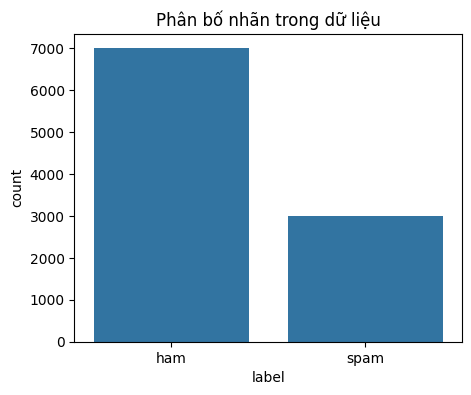

In [ ]:
# Đọc dữ liệu
df = pd.read_csv('vietnamese_sms_dataset.csv', encoding="utf-8-sig")

#Kiểm tra kích thước
print(f"Kích thước dữ liệu: {df.shape}")
print(df.info())

# Kiểm tra phân bố nhãn
print(df['label'].value_counts())
print(f"Tỷ lệ nhãn:\n{df['label'].value_counts(normalize=True)}")

# Hiển thị biểu đồ phân bố nhãn
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='label')
plt.title('Phân bố nhãn trong dữ liệu')
plt.show()

In [ ]:
import re
import unicodedata
from underthesea import word_tokenize

# Stopwords
vietnamese_stopwords = set([
    'và', 'của', 'cho', 'là', 'để', 'trong', 'có', 'không', 'được', 'tại', 'những',
    'với', 'này', 'về', 'như', 'đó', 'các', 'một', 'từ', 'bạn', 'tôi', 'làm', 'việc',
    'theo', 'năm', 'khi', 'sẽ', 'đã', 'lên', 'đây', 'nhưng', 'do', 'vào', 'ra', 'nếu',
    'thì', 'nên', 'quá', 'lại', 'đến', 'đi', 'còn', 'chỉ', 'mà', 'vì', 'cũng', 'ngoài',
    'rồi', 'hay', 'nào', 'sau', 'trên', 'dưới', 'đang', 'mới', 'bởi', 'ở', 'phải', 'vẫn',
    'luôn', 'làm', 'hơn', 'thế', 'đều', 'vậy', 'rất', 'cần', 'lúc', 'bị', 'sao', 'ai',
    'mình', 'chúng', 'cùng', 'đôi', 'trước', 'nhiều', 'cứ', 'để', 'thật', 'chứ', 'suốt',
    'rằng', 'nhé', 'vừa', 'đây', 'kia', 'nhỉ', 'nhá', 'ạ', 'à', 'á', 'ấy', 'ầy',
    'anh', 'chị', 'em', 'cô', 'chú', 'ông', 'bà', 'họ', 'ta','hôm',
    'nay', 'mai', 'gì', 'đó', 'ừ', 'ơ', 'ừm', 'hừm', 'huhu', 'híc', 'ừh',
    'k', 'ok', 'oke', 'đc', 'đc rồi', 'rồi', 'đâu', 'hả', 'hơ', 'khôg', 'khong',
    'úi', 'ôi', 'ồ', 'ơi', 'chứ', 'chí', 'chịu', 'kệ', 'hay', 'thôi', 'nữa',
    'tiếp', 'tiếp theo', 'nhé', 'nè', 'nà', 'nha', 'nữa'
])

def clean_text(text: str):
    txt = text.lower()
    txt = re.sub(r'https?://\S+|www\.\S+', ' <url> ', txt)
    txt = re.sub(r'\b\d{2,4}[.\-]?\d{2,4}[.\-]?\d{2,4}\b', ' <phone> ', txt)
    txt = re.sub(r'\b(?:[0-3]?\d)[/](?:[0-1]?\d)[/](?:20[0-2]\d)\b', ' <date> ', txt)
    txt = re.sub(r'\b\d+(?:[.,]\d+)*\s*(?:k|K|đ|vnd|VND|tr|Tr)\b', ' <money> ', txt)
    txt = re.sub(r'[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F'
                 r'\U0001F680-\U0001F6FF\U00002700-\U000027BF]+', ' <emoji> ', txt)
    txt = re.sub(r'[^0-9a-zA-Z\sàáảãạăắằẳẵặâấầẩẫậèéẻẽẹêếềểễệ'
                 r'ìíỉĩịòóỏõọôốồổỗộơớờởỡợùúủũụưứừửữựỳýỷỹỵđ<>]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()

    txt = unicodedata.normalize('NFC', txt)

    tokens = word_tokenize(txt)
    filtered_tokens = []
    for tk in tokens:
        tk = tk.strip()
        if not tk:
            continue
        if tk in ['<url>', '<phone>', '<date>', '<money>', '<emoji>']:
            filtered_tokens.append(tk)
            continue
        if tk in vietnamese_stopwords:
            continue
        if any(c.isalnum() for c in tk):
            filtered_tokens.append(tk)

    cleaned_message = ' '.join(filtered_tokens)
    return filtered_tokens, cleaned_message

df['tokens'], df['cleaned_message'] = zip(*df['message'].apply(clean_text))

for i in range(20):
    print(f"Văn bản chưa xử lý: {df['message'].iloc[i]}")
    print(f"Tokens: {df['tokens'].iloc[i]}")
    print(f"Văn bản đã xử lý: {df['cleaned_message'].iloc[i]}")
    print("-" * 70)


Văn bản chưa xử lý: Bạn có muốn cùng mình ăn trưa không?
Tokens: ['muốn', 'ăn', 'trưa']
Văn bản đã xử lý: muốn ăn trưa
----------------------------------------------------------------------
Văn bản chưa xử lý: Cảm ơn bạn đã giúp đỡ.
Tokens: ['cảm ơn', 'giúp đỡ']
Văn bản đã xử lý: cảm ơn giúp đỡ
----------------------------------------------------------------------
Văn bản chưa xử lý: Ê mai có đic f vs nhóm k? T 4h xong việc, qua đón nhé.
Tokens: ['ê mai', 'đic', 'f', 'vs', 'nhóm', 't', '4', 'h', 'xong', 'qua', 'đón']
Văn bản đã xử lý: ê mai đic f vs nhóm t 4 h xong qua đón
----------------------------------------------------------------------
Văn bản chưa xử lý: mừng lễ 30/4, giảm đồng loạt 10% choq uý khách sử dụng các sản phẩm đồng hồ. thời gian áp dụng kể từ 19/12/2022. xem chi tiết tại https://chiase.mobifone.vn.lol
Tokens: ['mừng', 'lễ', '30', '4', 'giảm', 'đồng loạt', '10', 'choq', 'úy', 'khách', 'sử dụng', 'sản phẩm', 'đồng hồ', 'thời gian', 'áp dụng', 'kể', 'date', 'xem', 'chi 

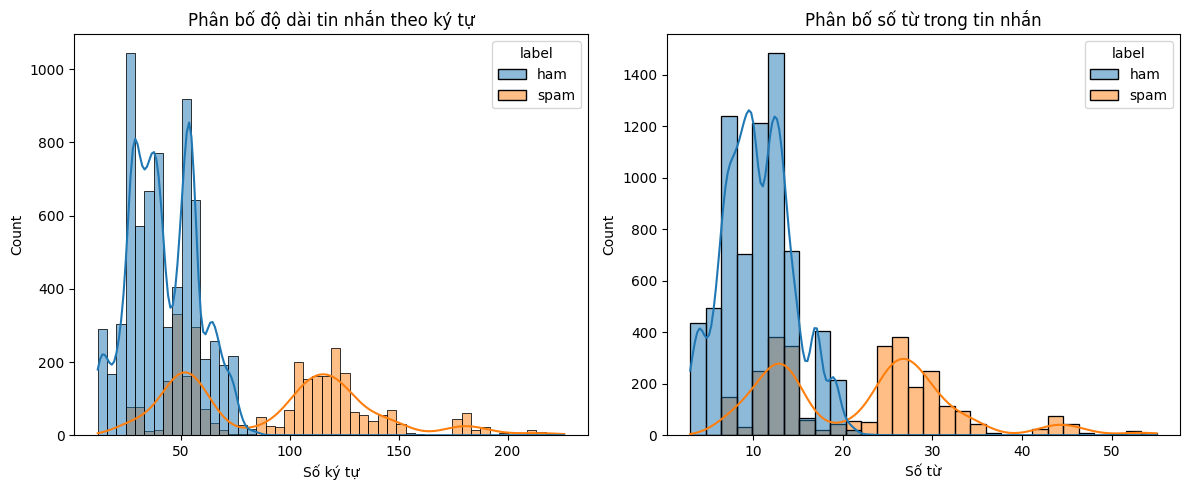

[('<', 4540), ('ngay', 1833), ('emoji', 1738), ('url', 1607), ('chi', 1363), ('nhận', 938), ('money', 859), ('phone', 843), ('ngày', 835), ('tiết', 819), ('1', 779), ('tay', 727), ('date', 714), ('phẩm', 640), ('hàng', 614), ('giá', 609), ('nhanh', 599), ('sản', 594), ('xem', 577), ('tặng', 542)]
[('<', 1480), ('h', 1248), ('học', 1159), ('nhớ', 1131), ('t', 1056), ('hôm', 811), ('emoji', 789), ('m', 734), ('ko', 722), ('nay', 668), ('ngày', 642), ('nha', 609), ('gia', 576), ('nộp', 542), ('trc', 540), ('tao', 531), ('mai', 513), ('qua', 512), ('con', 511), ('tra', 506)]


In [ ]:
df['message_length'] = df['cleaned_message'].apply(len)
df['word_count'] = df['cleaned_message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(data=df,x='message_length', hue='label', bins=50, kde=True)
plt.title('Phân bố độ dài tin nhắn theo ký tự')
plt.xlabel('Số ký tự')

plt.subplot(1,2,2)
sns.histplot(data=df,x='word_count', hue='label', bins=30, kde=True)
plt.title('Phân bố số từ trong tin nhắn')
plt.xlabel('Số từ')

plt.tight_layout()
plt.show()

def get_top_words(text_series, n=20):
  all_words = ' '.join(text_series).split()
  word_counts = Counter(all_words)
  return word_counts.most_common(n)

spam_texts = df[df['label'] == 'spam']['cleaned_message']
ham_texts = df[df['label'] == 'ham']['cleaned_message']

print(get_top_words(spam_texts))
print(get_top_words(ham_texts))

# Train mô hình

In [ ]:
label_mapping = {"spam":1, "ham":0}
df['label'] = df['label'].map(label_mapping)
print(df['label'].head(10))

0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: label, dtype: int64


In [ ]:
import math, random, calendar
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
)
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix
)
from torch.nn import BCEWithLogitsLoss

# Setup
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Dataset class với EDA augmentation
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, augment=False):
        self.texts, self.labels = texts, labels
        self.tokenizer, self.max_length = tokenizer, max_length
        self.augment = augment

    def __len__(self):
        return len(self.texts)

    def _eda(self, text):
        words = text.split()
        if len(words) == 1: return words
        # Random deletion
        if len(words) > 1 and random.random() < 0.1:
            del words[random.randrange(len(words))]
        # Random swap
        if len(words) > 1 and random.random() < 0.1:
            i, j = random.sample(range(len(words)), 2)
            words[i], words[j] = words[j], words[i]
        return " ".join(words)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.augment:
            text = self._eda(text)
        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids":      enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels":         torch.tensor(int(self.labels[idx]), dtype=torch.float)
        }

#Tải tokenizer của PhoBERT và chia tập dữ liệu.
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
train_df = df.sample(frac=0.9, random_state=SEED)
test_df  = df.drop(train_df.index)
train_texts, train_labels = train_df["cleaned_message"].tolist(), train_df["label"].tolist()
test_texts,  test_labels  = test_df["cleaned_message"].tolist(),  test_df["label"].tolist()

#DataLoaders
train_ds = SMSDataset(train_texts, train_labels, tokenizer, augment=True)
test_ds  = SMSDataset(test_texts,  test_labels,  tokenizer, augment=False)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

#Tải mô hình và thiết lập fine-tuning
cfg = AutoConfig.from_pretrained(
    "vinai/phobert-base",
    num_labels=1,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", config=cfg)
for name, p in model.named_parameters():
    if name.startswith("roberta.encoder.layer"):
        layer_id = int(name.split(".")[3])
        p.requires_grad = layer_id >= 8
    else:
        p.requires_grad = True
model.to(device)

#Class‐weighted loss để cân bằng
spam_count = sum(train_labels)
ham_count  = len(train_labels) - spam_count
pos_weight = torch.tensor(ham_count/spam_count, device=device)
loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)

#6. Thiết lập tối ưu huấn luyện.
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-5,
    weight_decay=0.01,
    eps=1e-8
)
total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#Training loop
best_val_loss = math.inf
for epoch in range(1, 6):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outs = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
        )
        logits = outs.logits.view(-1)
        labels = batch["labels"].to(device)
        loss   = loss_fn(logits, labels)
        loss.backward() #Tính gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #Cắt giá trị gradient nếu giá trị tổng norm > 1 tránh exploding gradient
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            outs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
            )
            logits = outs.logits.view(-1)
            labels = batch["labels"].to(device)
            val_loss += loss_fn(logits, labels).item()
    val_loss /= len(test_loader)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    if val_loss < best_val_loss :
      best_val_loss = val_loss
      torch.save(model.state_dict(), "best_model.pt")

#8 Đánh giá mô hình
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds, trues, probs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        outs = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
        )
        logit  = outs.logits.view(-1)
        prob   = torch.sigmoid(logit)
        preds += (prob > 0.5).cpu().int().tolist()
        probs += prob.cpu().tolist()
        trues += batch["labels"].int().tolist()

acc  = accuracy_score(trues, preds)
prec, rec, f1, _ = precision_recall_fscore_support(trues, preds, average="binary", zero_division=0)
auc  = roc_auc_score(trues, probs)
cm   = confusion_matrix(trues, preds)

print(f"Final Test → Acc {acc:.4f} Prec {prec:.4f} Rec {rec:.4f} F1 {f1:.4f} AUC {auc:.4f}")
print("CM:", cm)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: train_loss=0.4799, val_loss=0.3841
Epoch 2: train_loss=0.1815, val_loss=0.1656
Epoch 3: train_loss=0.1581, val_loss=0.0546
Epoch 4: train_loss=0.1808, val_loss=0.0546
Epoch 5: train_loss=0.1548, val_loss=0.0546
Final Test → Acc 0.9920 Prec 0.9750 Rec 1.0000 F1 0.9873 AUC 0.9999
CM: [[680   8]
 [  0 312]]
